In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda
from keras.models import Model
from keras.metrics import binary_crossentropy
import keras.backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

from scipy.stats import norm
from sklearn.manifold import Isomap

Using TensorFlow backend.


In [2]:
from src.utils import process_mnist,gen_trajectory,gen_sorted_isomap
from src.models import build_dense,CachedModel

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


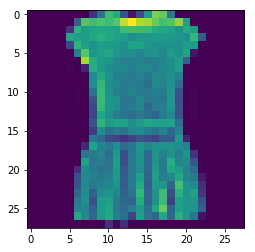

In [4]:
plt.imshow(x_train[3].reshape(28,28))

In [5]:
encoding_dim = 64
latent_dim = 2
inputs = Input(shape=input_shape)
encoded = build_dense(inputs,[512,encoding_dim],activations='relu')

In [6]:
z_mean = Dense(latent_dim)(encoded)
z_log_sigma = Dense(latent_dim)(encoded)

def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

lat_vec = Lambda(sampler)([z_mean,z_log_sigma])

In [7]:
decoded_mean = build_dense(lat_vec,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])

In [8]:
vae = Model(inputs,decoded_mean)
def vae_loss(input_img,output):
    # Reconstruction loss
    reconstruction_loss = K.sum(K.square(output-input_img))
    kl_loss = -0.5*K.sum(1+(2*z_log_sigma)-K.square(z_mean)- K.square(K.exp(z_log_sigma)),axis=-1)
    total_loss = K.mean(reconstruction_loss)+kl_loss
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
vae.compile(loss=vae_loss,optimizer='adadelta')

In [9]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           32832       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            130         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [10]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 74us/step - loss: 4689.4874 - val_loss: 3508.2418
Epoch 2/50
60000/60000 [==============================] - 3s 54us/step - loss: 3415.0632 - val_loss: 3069.8405
Epoch 3/50
60000/60000 [==============================] - 3s 51us/step - loss: 3088.7502 - val_loss: 2999.9474
Epoch 4/50
60000/60000 [==============================] - 3s 53us/step - loss: 2961.7688 - val_loss: 2852.6096
Epoch 5/50
60000/60000 [==============================] - 3s 55us/step - loss: 2881.4137 - val_loss: 2789.4998
Epoch 6/50
60000/60000 [==============================] - 3s 52us/step - loss: 2830.7174 - val_loss: 2789.0793
Epoch 7/50
60000/60000 [==============================] - 3s 51us/step - loss: 2794.1552 - val_loss: 2726.9595
Epoch 8/50
60000/60000 [==============================] - 3s 49us/step - loss: 2758.7871 - val_loss: 2713.4574
Epoch 9/50
60000/60000 [==============================] - 3s 5

In [11]:
encoder = Model(inputs,z_mean)
decoder_inp = Input(shape=(2,))
# _generator_x = build_dense(decoder_inp,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])
# generator = Model(decoder_inp,decoded_mean)
# print(generator.summary())
dec_layers = vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [12]:
x_test_encoded = encoder.predict(x_test,batch_size=128)

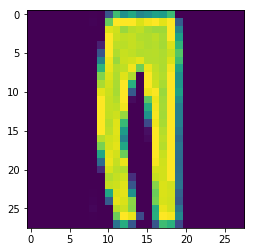

In [13]:
plt.imshow(x_test[2].reshape(28,28))
# generator.predict()

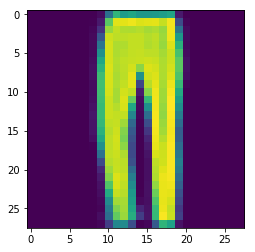

In [14]:
# x_test_encoded[2]
dec_test = generator.predict(x_test_encoded[:5])
plt.imshow(dec_test[2].reshape(28,28))

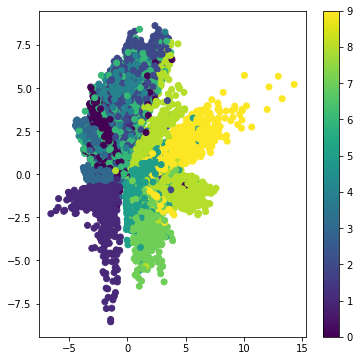

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [19]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 209,250
Trainable params: 209,250
Non-trainable params: 0
_________________________________________________________________


In [20]:
from datetime import date
print(date.today())
save_dir = '/home/elijahc/projects/vae/models/'+str(date.today())+'/'


2018-07-06


In [21]:
# vae.save(save_dir+'vae_3layer.h5',include_optimizer=False)
# encoder.save(save_dir+'enc.h5',include_optimizer=False)

In [22]:
x0 = np.array([0,-5])
x1 = np.array([0,5])
traj = gen_trajectory(x0,x1,delta=.1)
# traj[:3].shape
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,28,28)
dec_traj.shape

(11, 28, 28)

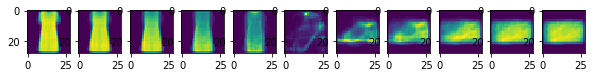

In [23]:
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

In [24]:
enc_32 = vae.layers[6]
enc_256 = vae.layers[7]

In [25]:
encoder.trainable=False
x = enc_32(encoder.outputs[0])
y_class_oh = Dense(10,activation='softmax')(x)

In [26]:
med = Model(inputs=inputs,outputs=y_class_oh)
med.layers[-2].trainable=False
for l in med.layers[1:4]:
    l.trainable=False
med.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
y_train_oh = to_categorical(y_train,num_classes=10)

In [28]:
y_train_oh.shape

(60000, 10)

In [29]:
med.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 209,676
Trainable params: 330
Non-trainable params: 209,346
_________________________________________________________________


In [30]:
med.fit(x_train,y_train_oh,
        batch_size=128,
        epochs=25,
        validation_data=(x_test,to_categorical(y_test,num_classes=10))
       )

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 28us/step - loss: 1.5452 - acc: 0.4958 - val_loss: 1.1699 - val_acc: 0.6223
Epoch 2/25
60000/60000 [==============================] - 2s 26us/step - loss: 1.0916 - acc: 0.6479 - val_loss: 1.0551 - val_acc: 0.6570
Epoch 3/25
60000/60000 [==============================] - 2s 27us/step - loss: 1.0122 - acc: 0.6731 - val_loss: 0.9986 - val_acc: 0.6799
Epoch 4/25
60000/60000 [==============================] - 1s 25us/step - loss: 0.9660 - acc: 0.6869 - val_loss: 0.9603 - val_acc: 0.6887
Epoch 5/25
60000/60000 [==============================] - 1s 25us/step - loss: 0.9342 - acc: 0.6913 - val_loss: 0.9338 - val_acc: 0.6906
Epoch 6/25
60000/60000 [==============================] - 2s 28us/step - loss: 0.9106 - acc: 0.6961 - val_loss: 0.9135 - val_acc: 0.6924
Epoch 7/25
60000/60000 [==============================] - 2s 25us/step - loss: 0.8925 - acc: 0.6978 - val_loss: 0.8980 - val_acc

In [31]:
x_g = generator.predict(x_test_encoded[:3])
y_test_im = x_g.reshape(3,28,28)

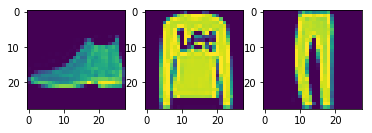

In [32]:
x_test_im = x_test.reshape(10000,28,28)[:3]

fig,axs = plt.subplots(1,3)
for im,ax in zip(x_test_im,axs):
    ax.imshow(im)

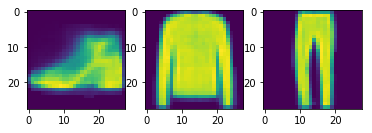

In [33]:
fig,axs = plt.subplots(1,3)
for im,ax in zip(y_test_im,axs):
    ax.imshow(im)

In [34]:
med.evaluate(x_test,to_categorical(y_test,num_classes=10))

10000/10000 [==============================] - 1s 54us/step


[0.8083149237632752, 0.7078]